<a href="https://colab.research.google.com/github/kshitijmalvankar/HealthCareAI/blob/main/HealthCareAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Healthcare AI Datasets/Brain_MRI

/content/drive/My Drive/Healthcare AI Datasets/Brain_MRI


In [4]:
brain_df = pd.read_csv('data_mask.csv')

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df.head(50)

patient_id  ... mask
0   TCGA_CS_5395_19981004  ...    0
1   TCGA_CS_5395_19981004  ...    0
2   TCGA_CS_5395_19981004  ...    0
3   TCGA_CS_5395_19981004  ...    0
4   TCGA_CS_5395_19981004  ...    0
5   TCGA_CS_5395_19981004  ...    0
6   TCGA_CS_5395_19981004  ...    0
7   TCGA_CS_5395_19981004  ...    0
8   TCGA_CS_5395_19981004  ...    0
9   TCGA_CS_5395_19981004  ...    0
10  TCGA_CS_5395_19981004  ...    0
11  TCGA_CS_5395_19981004  ...    0
12  TCGA_CS_5395_19981004  ...    0
13  TCGA_CS_5395_19981004  ...    0
14  TCGA_CS_5395_19981004  ...    0
15  TCGA_CS_5395_19981004  ...    0
16  TCGA_CS_5395_19981004  ...    0
17  TCGA_CS_5395_19981004  ...    0
18  TCGA_CS_5395_19981004  ...    0
19  TCGA_CS_5395_19981004  ...    0
20  TCGA_CS_4944_20010208  ...    0
21  TCGA_CS_4944_20010208  ...    0
22  TCGA_CS_4944_20010208  ...    0
23  TCGA_CS_4944_20010208  ...    0
24  TCGA_CS_4944_20010208  ...    0
25  TCGA_CS_4944_20010208  ...    0
26  TCGA_CS_4944_20010208  ...    0
27  TCGA_CS_4944_20010208  ...    0
28  TCGA_CS_4944_20010208  ...    0
29  TCGA_CS_4944_20010208  ...    0
30  TCGA_CS_4944_20010208  ...    0
31  TCGA_CS_4944_20010208  ...    0
32  TCGA_CS_4944_20010208  ...    0
33  TCGA_CS_4944_20010208  ...    0
34  TCGA_CS_4944_20010208  ...    0
35  TCGA_CS_4944_20010208  ...    0
36  TCGA_CS_4944_20010208  ...    0
37  TCGA_CS_4944_20010208  ...    0
38  TCGA_CS_4944_20010208  ...    0
39  TCGA_CS_4944_20010208  ...    0
40  TCGA_CS_4941_19960909  ...    0
41  TCGA_CS_4941_19960909  ...    0
42  TCGA_CS_4941_19960909  ...    0
43  TCGA_CS_4941_19960909  ...    0
44  TCGA_CS_4941_19960909  ...    0
45  TCGA_CS_4941_19960909  ...    0
46  TCGA_CS_4941_19960909  ...    0
47  TCGA_CS_4941_19960909  ...    0
48  TCGA_CS_4941_19960909  ...    0
49  TCGA_CS_4941_19960909  ...    0

[50 rows x 4 columns]

In [5]:
brain_df.mask_path[1] 
# Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [6]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [7]:
#Checking whether the dataset is balanced
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# Prforming Data Visualization and Exploring dataset

In [ ]:
import plotly.graph_objects as go
fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(255,0,0)', marker_line_width = 3, opacity = 0.6)
fig.show()

In [ ]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [ ]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

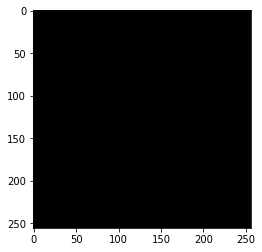

In [ ]:
plt.imshow(cv2.imread(brain_df.mask_path[200]))

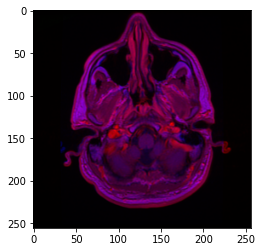

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[200]))

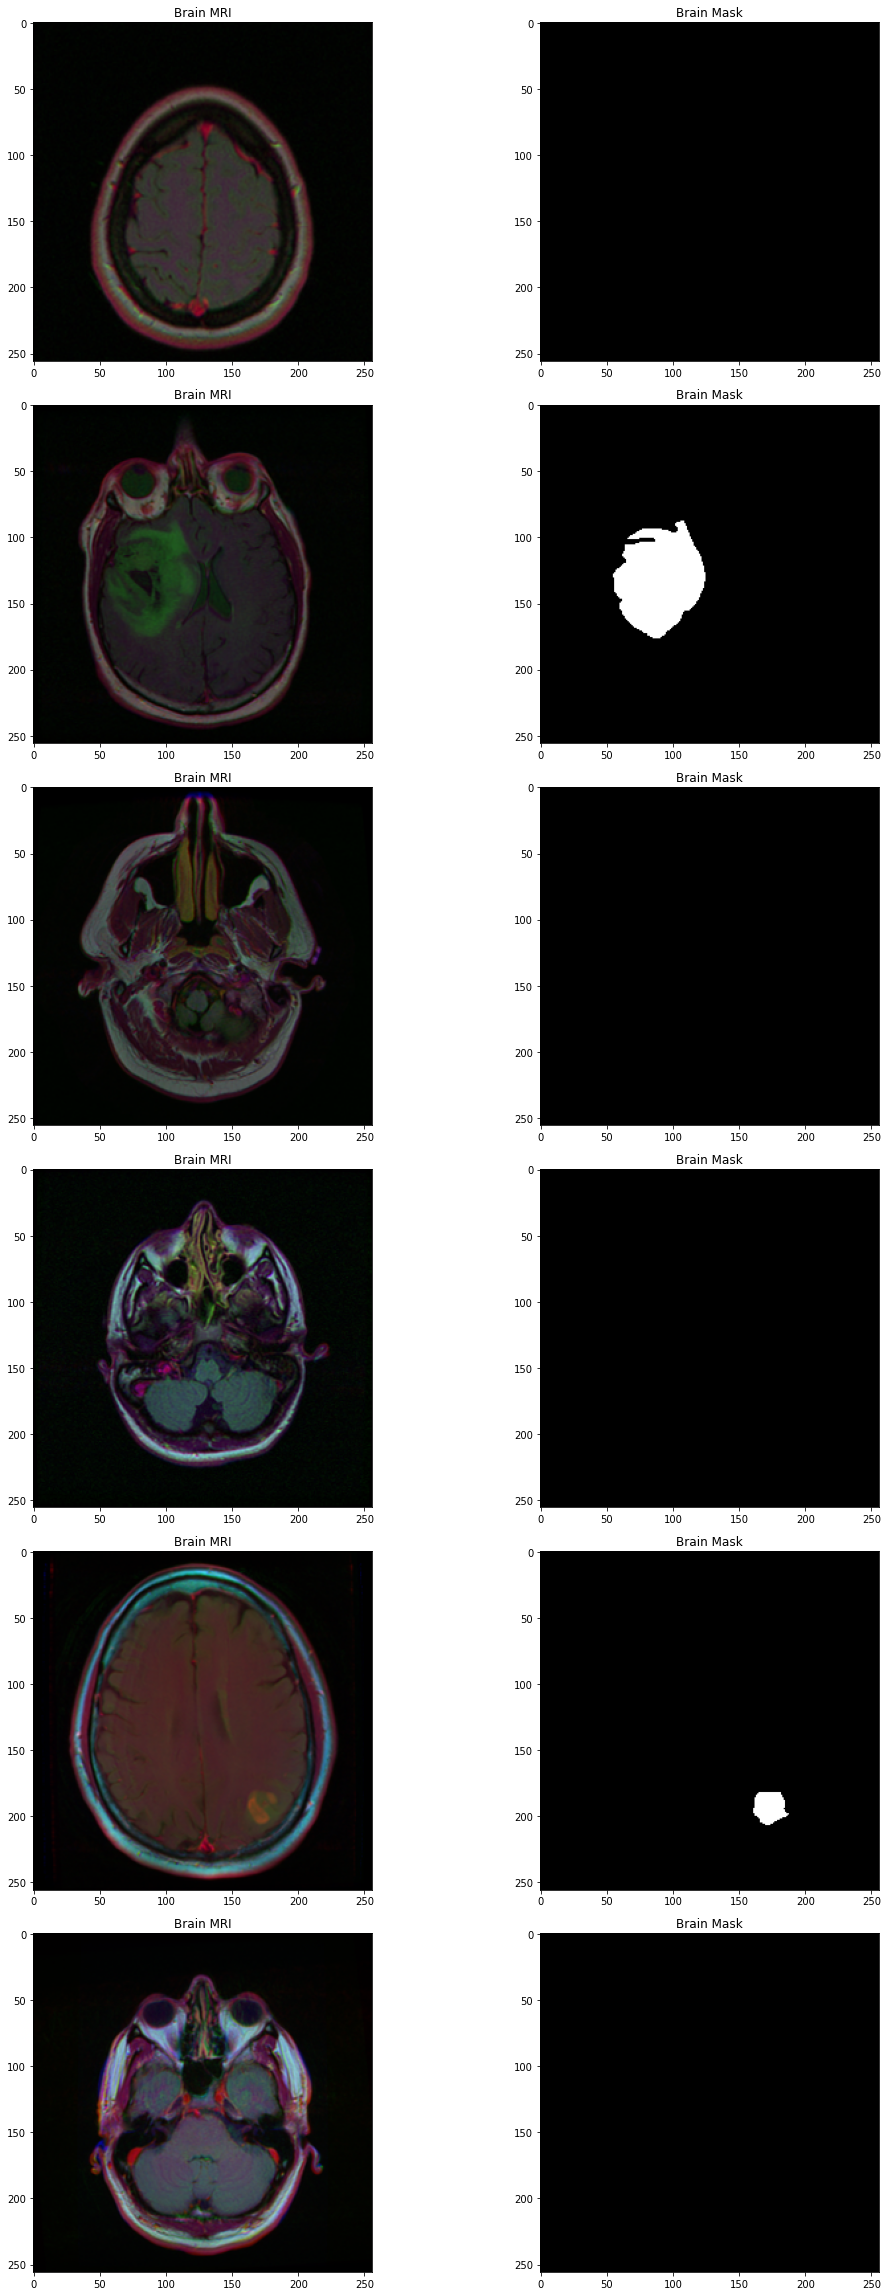

In [ ]:
#Visualizing MRI and Mask correspondng to the image
import random
fig, axs = plt.subplots(6,2,figsize = (16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
  axs[count][1].title.set_text("Brain Mask")
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count+=1

fig.tight_layout()




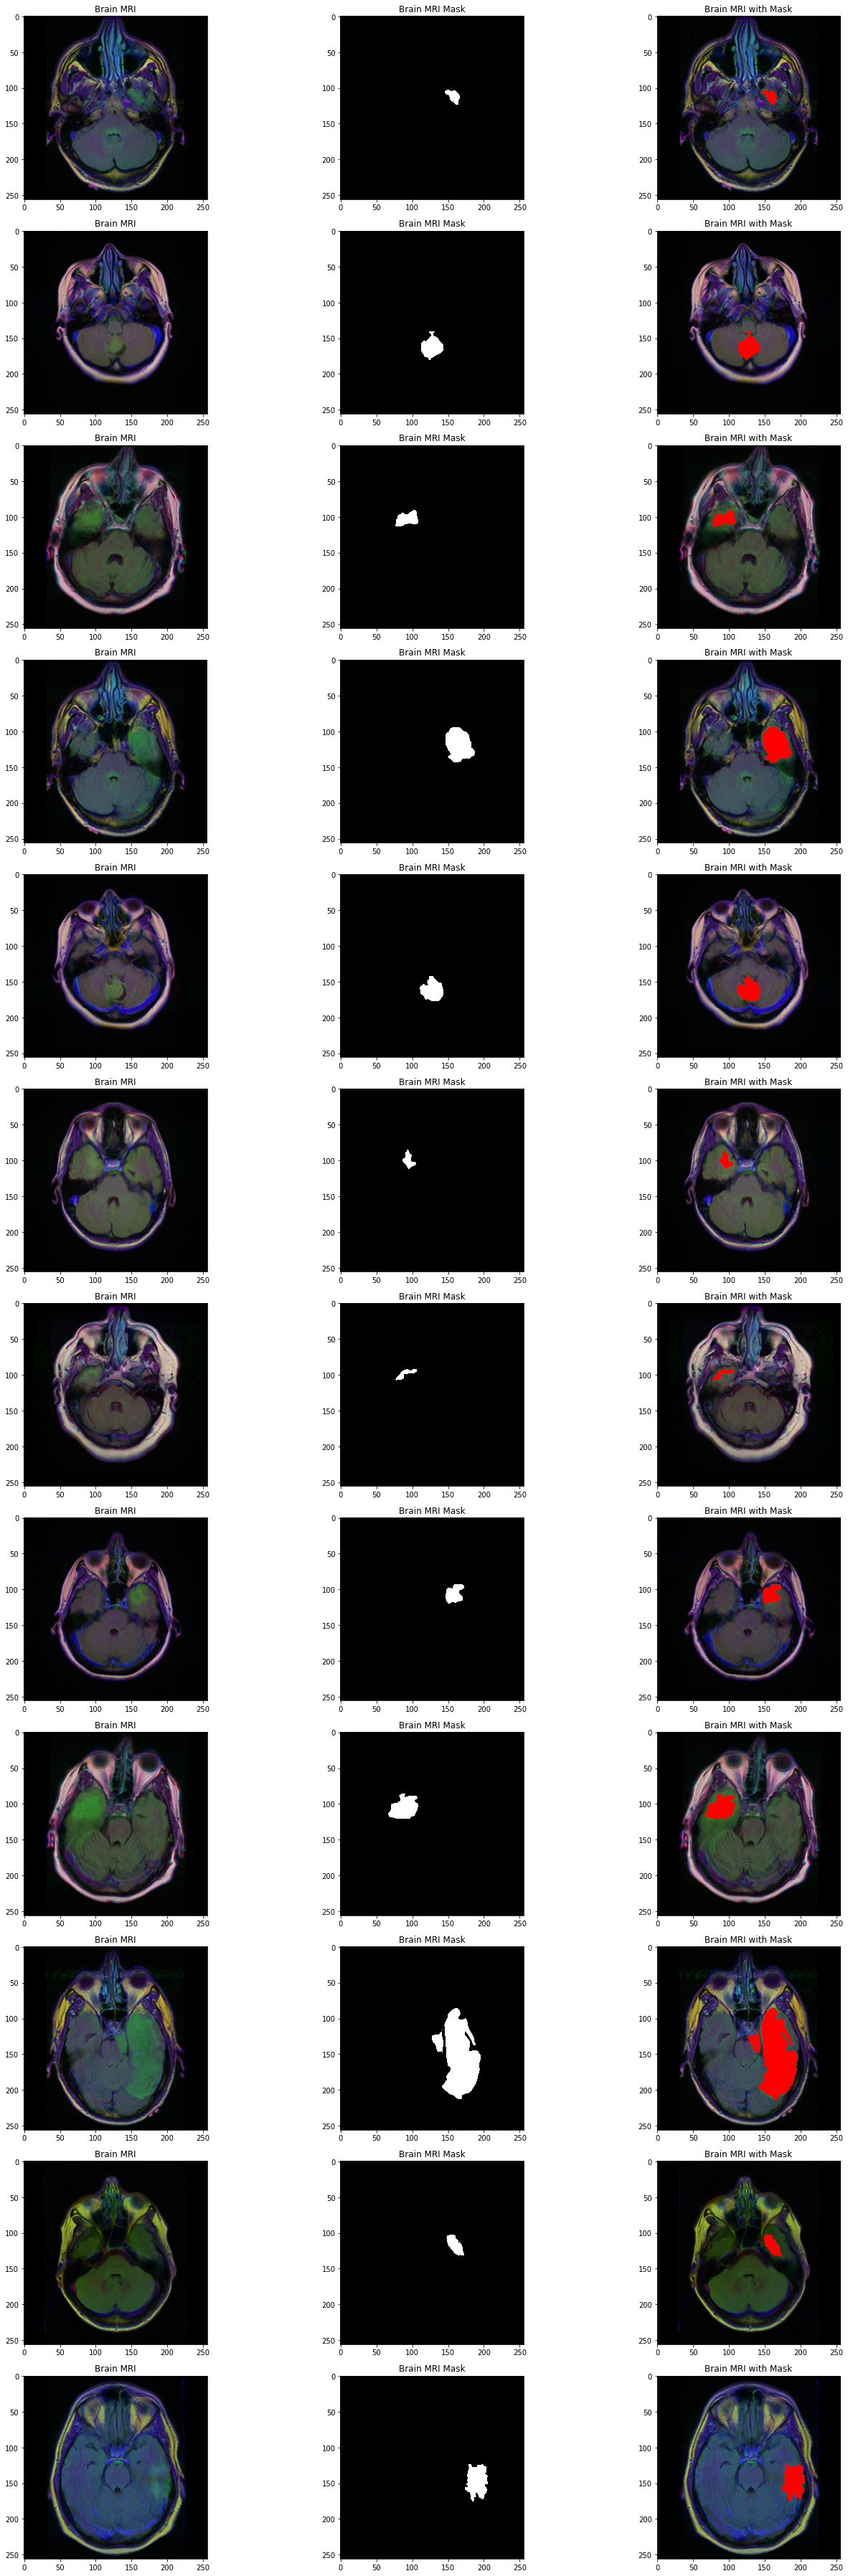

In [ ]:
count = 0
fig, axs = plt.subplots(12,3, figsize = (20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Brain MRI Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("Brain MRI with Mask")
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()



# Training a Classifier Model to check whether tumour exists

In [8]:
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train.shape

(3929, 3)

In [9]:
#converting the 'mask' column to string format
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [10]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [11]:
#Splitting data into training data and testing data
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)


In [12]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.15)


In [13]:
train_generator = datagen.flow_from_dataframe(
  dataframe = train,
  directory = './',
  x_col = 'image_path',
  y_col = 'mask',
  subset = "training",
  batch_size = 16,
  shuffle = True,
  class_mode = "categorical",
  target_size = (256,256)
)

valid_generator = datagen.flow_from_dataframe(
  dataframe = train,
  directory = './',
  x_col = 'image_path',
  y_col = 'mask',
  subset = "validation",
  batch_size = 16,
  shuffle = True,
  class_mode = "categorical",
  target_size = (256,256)
)

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))


Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [14]:
#Getting the ResNET50 base model
basemodel = ResNet50(weights = 'imagenet', include_top=False, input_tensor= Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
#Freezing the weights of basemodel for transfer learninf
for layer in basemodel.layers:
  layers.trainable = False

In [16]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256,activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256,activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2,activation='softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
#compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [18]:
earlystopping  = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5",verbose=1, save_best_only = True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/10
177/177 [==============================] - 1333s 8s/step - loss: 0.1086 - accuracy: 0.9749 - val_loss: 0.1235 - val_accuracy: 0.9698

Epoch 00001: val_loss improved from inf to 0.12352, saving model to classifier-resnet-weights.hdf5
Epoch 2/10
177/177 [==============================] - 40s 225ms/step - loss: 0.0626 - accuracy: 0.9804 - val_loss: 0.1027 - val_accuracy: 0.9677

Epoch 00002: val_loss improved from 0.12352 to 0.10266, saving model to classifier-resnet-weights.hdf5
Epoch 3/10
177/177 [==============================] - 41s 230ms/step - loss: 0.0734 - accuracy: 0.9782 - val_loss: 0.1888 - val_accuracy: 0.9536

Epoch 00003: val_loss did not improve from 0.10266
Epoch 4/10
177/177 [==============================] - 42s 235ms/step - loss: 0.0964 - accuracy: 0.9713 - val_loss: 0.1886 - val_accuracy: 0.9315

Epoch 00004: val_loss did not improve from 0.10266
Epoch 5/10
177/177 [==============================] - 42s 235ms/step - loss: 0.0429 - accuracy: 0.9870 - val_loss

In [ ]:
#Saving the model for future use
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

# Assessing the trained model

In [19]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])


In [20]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 136s 4s/step


In [22]:
test_predict.shape

(576, 2)

In [23]:
test_predict

array([[1.0000000e+00, 8.2626462e-13],
       [5.0451338e-10, 1.0000000e+00],
       [2.0771907e-11, 1.0000000e+00],
       ...,
       [6.3432346e-04, 9.9936575e-01],
       [9.9999106e-01, 8.9097693e-06],
       [9.9912614e-01, 8.7392627e-04]], dtype=float32)

In [24]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [25]:
predict

array(['0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0',
       '0', '0', '0', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0',
       '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0',
       '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1',
       '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '0', '0',
       '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0',
       '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1',
       '0', '0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0',
       '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0',
       '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0',
       '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0',
       '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0

In [26]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [27]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9826388888888888

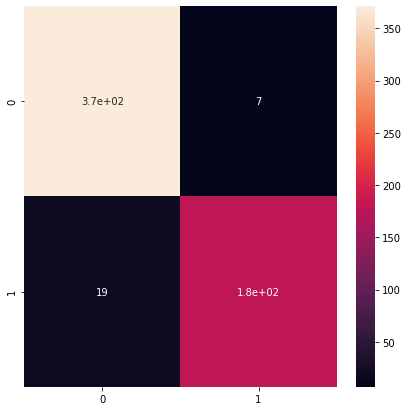

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       378
           1       0.96      0.90      0.93       198

   micro avg       0.95      0.95      0.95       576
   macro avg       0.96      0.94      0.95       576
weighted avg       0.96      0.95      0.95       576



/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



# Building a segmentation model to localize the tumour

In [28]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [29]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [30]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [31]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [32]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [33]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [34]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

# Training the segmentation RESUNET model

In [43]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import focal_tversky, tversky_loss, tversky

In [44]:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [45]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [46]:
history = model_seg.fit(training_generator, epochs = 20, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/20
72/72 [==============================] - 27s 344ms/step - loss: 0.7454 - tversky: 0.3225 - val_loss: 0.5775 - val_tversky: 0.5183

Epoch 00001: val_loss improved from inf to 0.57755, saving model to ResUNet-weights.hdf5
Epoch 2/20
72/72 [==============================] - 14s 188ms/step - loss: 0.4764 - tversky: 0.6257 - val_loss: 0.5895 - val_tversky: 0.5055

Epoch 00002: val_loss did not improve from 0.57755
Epoch 3/20
72/72 [==============================] - 14s 188ms/step - loss: 0.3772 - tversky: 0.7257 - val_loss: 0.6110 - val_tversky: 0.4809

Epoch 00003: val_loss did not improve from 0.57755
Epoch 4/20
72/72 [==============================] - 13s 178ms/step - loss: 0.3257 - tversky: 0.7740 - val_loss: 0.4386 - val_tversky: 0.6660

Epoch 00004: val_loss improved from 0.57755 to 0.43860, saving model to ResUNet-weights.hdf5
Epoch 5/20
72/72 [==============================] - 13s 179ms/step - loss: 0.3110 - tversky: 0.7868 - val_loss: 0.4707 - val_tversky: 0.6316

Epoch 

In [ ]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

# Assessing the model performance

In [47]:
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [48]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  ... has_mask
0    TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_2.tif  ...        0
1    TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_18...  ...        1
2    TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_20...  ...        1
3    TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_27...  ...        0
4    TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_23...  ...        0
..                                                 ...  ...      ...
585  TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_3.tif  ...        0
586  TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_18...  ...        1
587  TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_22...  ...        0
588  TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_2.tif  ...        0
589  TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_8.tif  ...        0

[590 rows x 3 columns]

In [49]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  ... has_mask
0  TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_2.tif  ...        0
1  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_18...  ...        1
2  TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_20...  ...        1
3  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_27...  ...        0
4  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_23...  ...        0

[5 rows x 5 columns]

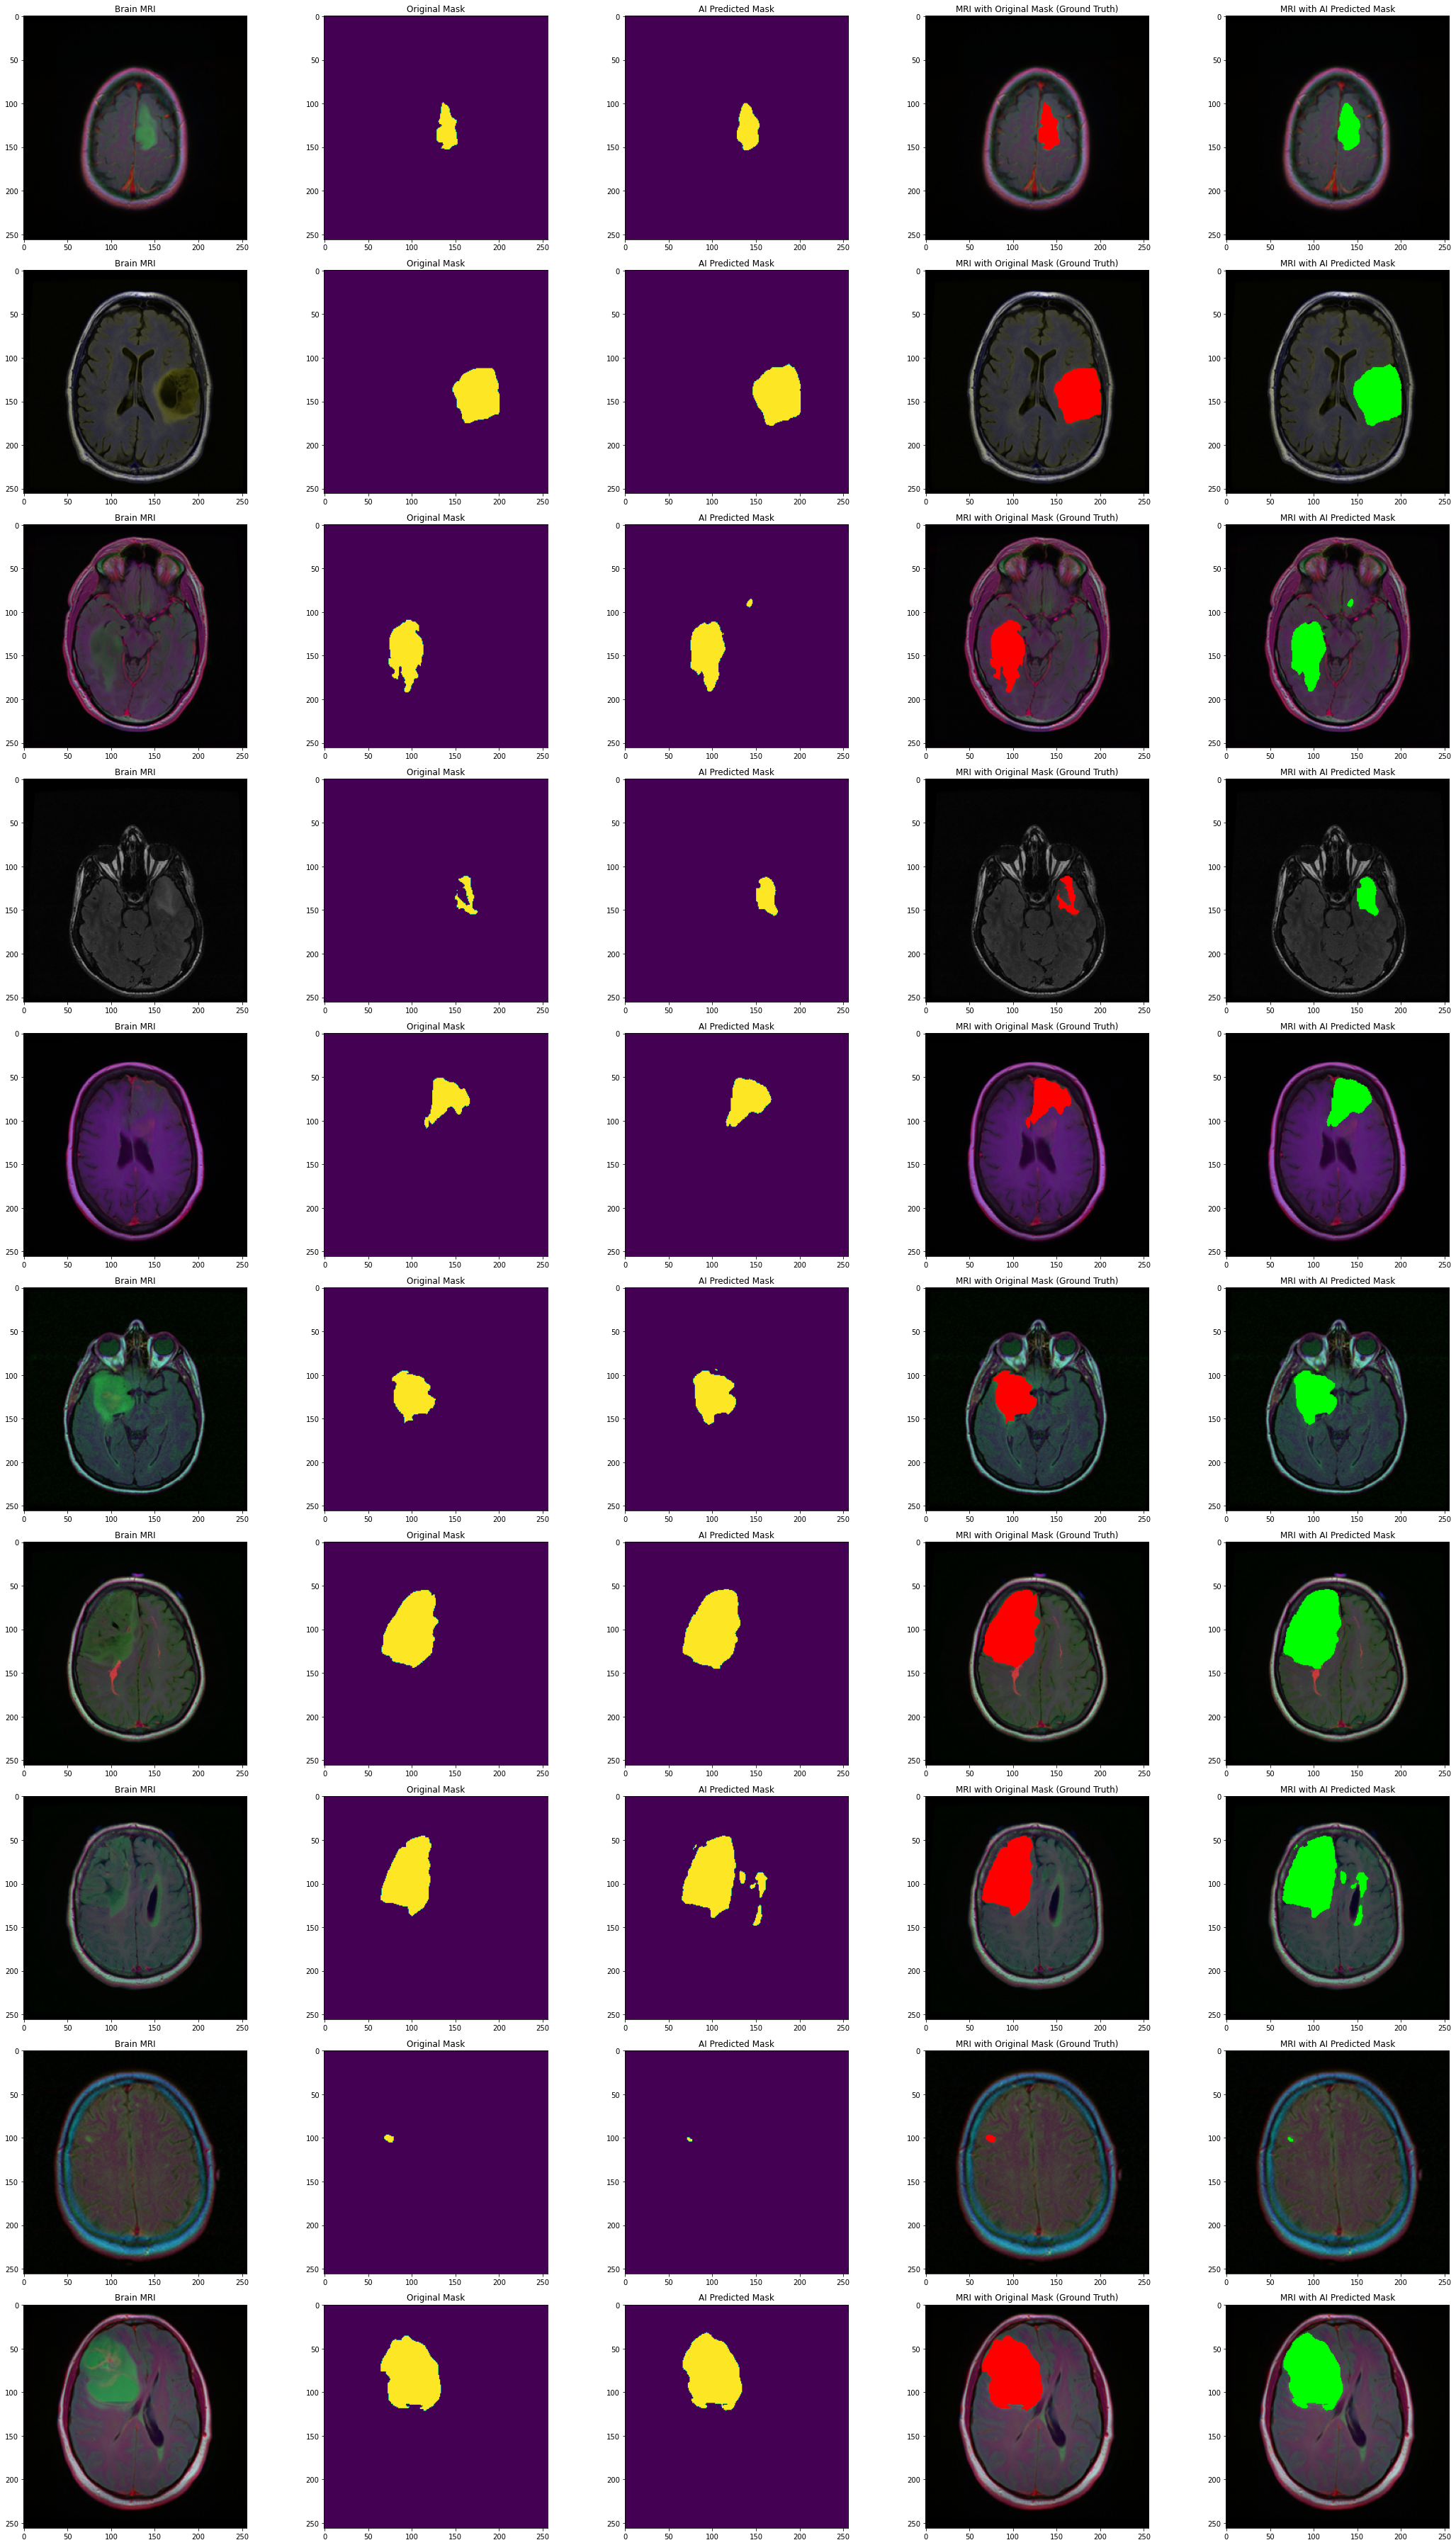

In [50]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()